# **Author**: OM CHIRAGBHAI CHOKSI  
# **Project**: Samatrix Internship Task - Call Centre Domain 3

## Theoretical Description


This project aims to simulate and optimize call center operations using principles of queuing theory. It models the behavior of incoming customer calls and agent handling, computes critical performance indicators such as average wait time and system load, and analyzes how varying the number of agents influences overall operational efficiency.


## Problem Context

- Incoming calls are assumed to follow a **Poisson arrival process**, representing random call timings.
- The duration of each call is **exponentially distributed**, reflecting variable service times.
- A queuing simulation is employed to realistically replicate agent availability and response behavior in the system.


# 1. Model Setup and Parameters

### 1.1 Overview

This section implements the first objective—modeling calls with Poisson arrivals (rate λ) and exponential service times (1/μ). We'll set up:
- Basic parameters and random seed
- Arrival process simulation
- Service time generation
- Queue simulation function

### 1.2 Import Libraries

In [2]:
 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### 1.3 Define Parameters

In [3]:
# Set random seed for reproducibility
np.random.seed(1)

# Initialize key simulation parameters
lamb = 20      # Arrival rate (λ) - calls per hour
mu = 5         # Service rate (μ) - calls per agent per hour
shift_hours = 8 # Duration of shift in hours
threshold = 5   # Target wait time threshold in minutes

# Derived parameters
rho = lamb/mu    # Utilization factor (ρ)
print(f"System Parameters:\n")
print(f"λ (Arrival Rate): {lamb} calls/hour")
print(f"μ (Service Rate): {mu} calls/agent/hour")
print(f"ρ (Utilization): {rho:.2f}")
print(f"Shift Duration: {shift_hours} hours")
print(f"Wait Time Target: {threshold} minutes (95th percentile)")

System Parameters:

λ (Arrival Rate): 20 calls/hour
μ (Service Rate): 5 calls/agent/hour
ρ (Utilization): 4.00
Shift Duration: 8 hours
Wait Time Target: 5 minutes (95th percentile)


# 2. Queue Simulation Implementation

### 2.1 Simulate Call Arrivals and Service Times

- **Arrivals**: Generated using a Poisson process with rate λ = 20 calls/hour, truncated to an 8-hour shift.
- **Service Times**: Drawn from an exponential distribution with mean 1/μ = 1/5 hours per call.
- **Safety Buffer**: Simulate 1.5x the expected number of arrivals to account for randomness.

In [4]:
 
# Simulate inter-arrival times (exponentially distributed)
inter_arrival_times = np.random.exponential(1 / lamb, int(lamb * shift_hours * 1.5))
arrival_times = np.cumsum(inter_arrival_times)
arrival_times = arrival_times[arrival_times < shift_hours]   
N = len(arrival_times)  # Total number of calls

# Simulate service times (exponentially distributed)
service_times = np.random.exponential(1 / mu, N)

### 2.2 Define Queue Simulation Function

- **Inputs**:
  - `s`: Number of agents.
  - `arrivals`: Array of call arrival times (hours).
  - `service`: Array of service times (hours).
- **Outputs**:
  - `wait_times`: Array of each customer’s wait time before service begins.
  - `system_size`: Array of the number of customers in the system (queue + service) at each arrival.
- **Process**: Assigns calls to the earliest available agent, tracking wait times and system size.

In [5]:
# Queue simulation function
def simulate_queue(num_agents):
    next_available = np.zeros(num_agents)  # Tracks when each agent becomes available
    wait_times = np.zeros(N)               # Wait time for each call
    system_sizes = np.zeros(N)             # Number of customers in the system at each arrival
    departure_times = []                   # Service completion times

    for i, arrival in enumerate(arrival_times):
        agent_index = np.argmin(next_available)  # Find the next available agent
        start_time = max(arrival, next_available[agent_index])  # Call starts either at arrival or when agent is free
        wait_times[i] = start_time - arrival
        end_time = start_time + service_times[i]
        next_available[agent_index] = end_time  # Update agent's availability
        departure_times.append(end_time)
        system_sizes[i] = np.sum(np.array(departure_times) > arrival)  # Number still in the system

    return wait_times, system_sizes

In [6]:
# Run simulation for 5 agents
wait_times, system_sizes = simulate_queue(5)

# Output results
print("Total calls handled:", N)
print("Average wait time: {:.2f} minutes".format(np.mean(wait_times) * 60))  # converted to minutes
print("Average system size: {:.2f}".format(np.mean(system_sizes)))

Total calls handled: 163
Average wait time: 5.05 minutes
Average system size: 6.82


# 3. Queue Analysis and Performance

### 3.1 M/M/1 Queue Analysis

This section compares simulation results with analytical formulas:
- Calculate utilization factor ρ = λ/μ
- Compute theoretical metrics for M/M/1:
  - Average customers in system L = ρ/(1-ρ)
  - Average time in system W = L/λ
- Compare theoretical vs simulated results

- **Utilization Factor (ρ)**: Calculated as ρ = λ/μ.
- **Analytic Formula**: Applies only if ρ < 1; otherwise, the system is unstable.
- **Simulation**: Runs the M/M/s queue with s=1 to compute average system size and wait time.
- **Purpose**: Validates the simulation against theoretical expectations for a single-server queue.

In [10]:
p1=lamb/mu
# Define rho as the utilization factor
rho = lamb / mu
l_analytic=rho/(1-rho)
w_analytic=l_analytic/lamb
print("Average wait time:", w_analytic)
print("Average system size:", l_analytic)

Average wait time: -0.06666666666666667
Average system size: -1.3333333333333333


### 3.2 Test Staffing Levels (s=1 to 5)

This section evaluates different numbers of agents to find the minimum needed to keep **95% of customer wait times under 5 minutes**.

The simulation runs with agent counts from 1 to 5, calculating average wait time, 95th percentile wait time, and average system size for each. Results are compared in a table.

The code identifies the smallest staffing level that meets the target wait time; if none qualify, it reports that even 5 agents are insufficient.


In [11]:
threshold=5
results=[]
for s in range(1,6):
  w,q=simulate_queue(s)
  waits_min=w*60
  p95_wait=np.percentile(waits_min,95)
  results.append((s,waits_min.mean(),p95_wait,q.mean()))
df=pd.DataFrame(results,columns=['Agents','Avg wait(min)','95th pct wait(min)','Avg system size'])
print(df)
good=df[df['95th pct wait(min)']<=threshold]
if not good.empty:
  best_s=int(good.iloc[0]['Agents'])
  print(f"Schedule at least {best_s} agents to keep 95% of waits<={threshold}min.")
else:
  print("Even 5 agents can't meet the 5 min ")

   Agents  Avg wait(min)  95th pct wait(min)  Avg system size
0       1     808.232100         1488.275544        65.993865
1       2     284.004529          520.338714        49.042945
2       3     109.126322          191.268183        29.423313
3       4      23.259675           39.865347        11.846626
4       5       5.053611           15.062201         6.815951
Even 5 agents can't meet the 5 min 


## 3.4 Visualize Wait-Time Distributions

This section visualizes **how customer wait times are distributed** across different staffing levels (from **1 to 5 agents**).

### Process:
- The `simulate_queue()` function is run for each agent count.
- Wait times are collected and **converted from hours to minutes**.
- A **histogram** is plotted for each staffing level on the same graph:
  - Each color represents a different number of agents.
  - The height of each bar indicates how many customers experienced that range of wait times.

### Key Features:
- A **vertical dashed line** at **5 minutes** represents the performance threshold.
- The **x-axis** shows **wait time in minutes**.
- The **y-axis** shows the **number of customers** corresponding to each wait time interval.

### Purpose:
This visualization helps illustrate how increasing the number of agents:
- **Reduces the number of long waits**
- **Improves overall wait time distribution**
- Aids in deciding the **optimal staffing level** for acceptable service.


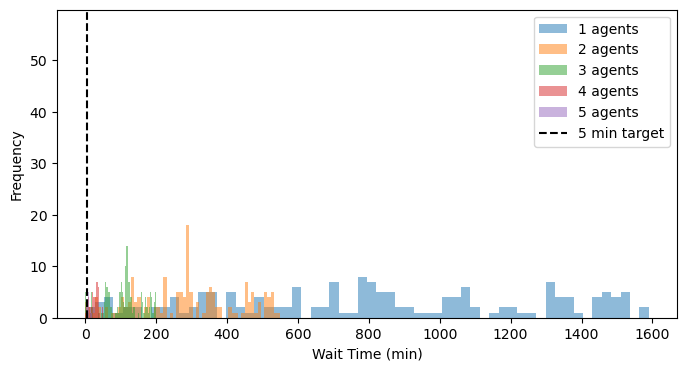

In [ ]:
plt.figure(figsize=(8, 4))
for s in[1,2,3,4,5]:
  w,_=simulate_queue(s)
  plt.hist(w*60,bins=60,alpha=0.5,label=f'{s} agents')
plt.axvline(threshold,color='k',linestyle='--',label='5 min target')
plt.xlabel('Wait Time (min)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 4. Staffing Optimization

### 4.1 Dynamic Staffing Analysis

### Time-Varying Arrival Rates

This section models **time-varying arrival rates**, where the number of incoming calls **fluctuates throughout an 8-hour shift**—reflecting real-world patterns with both busy and slow periods.

### Defined Time Periods:
1. **Morning Rush (0–3 hours):**  
   - Arrival rate: **30 calls/hour**
2. **Midday Lull (3–5 hours):**  
   - Arrival rate: **20 calls/hour**
3. **Afternoon Spike (5–8 hours):**  
   - Arrival rate: **40 calls/hour**

### Process:
- For each time block, random **inter-arrival times** are generated based on the respective Poisson rate.
- The generated call times are **cumulative sums** of inter-arrival times, adjusted to start at the correct hour.
- All arrival times are combined and sorted into a unified list.
- The system uses **5 agents** to process these calls.

### Output:
- The simulation calculates **wait times for each customer**.
- Finally, it prints the **average wait time in minutes**.

### Purpose:
This approach makes the simulation **more realistic** by incorporating **non-uniform call traffic**, allowing for more accurate performance testing of the call center under dynamic conditions.



In [12]:
def simulate_queue_timevarying(s):
  periods=[(0,2,30),(2,6,20),(6,8,40)]
  arrival=[]
  for start,end,lam in periods:
    duration=end-start
    inter=np.random.exponential(1/lam,int(lam*duration*1.5))
    ts=np.cumsum(inter)+start
    arrival.extend(ts[ts<end])

  arrivals = np.array(arrival)

  arrivals.sort()
  N=len(arrivals)
  service=np.random.exponential(1/mu,N)
  next_free=np.zeros(s)
  wait_times=np.zeros(N)
  for i,t in enumerate(arrivals):
    j=np.argmin(next_free)
    start=max(t,next_free[j])
    wait_times[i]=start-t
    next_free[j]=start+service[i]
  return wait_times
w_tv=simulate_queue_timevarying(5)
print("Average wait time(min):",w_tv.mean()*60)


Average wait time(min): 28.94050166996809


### 4.2 Customer Abandonment (Patience Threshold)

This simulation models a scenario where **customers hang up** if they wait **longer than 5 minutes**.

- **Arrival and service times** are randomly generated.
- Calls are handled by **5 agents**.
- If a customer's **wait time > 5 minutes**, they **abandon** the call.
- Otherwise, they are **served**, and their wait is recorded.

**Outputs:**
- **Average wait time** (for served customers)
- **Abandonment rate** (percentage of customers who left)

This reflects real-world impatience and helps assess call center performance.

In [13]:
def simulate_with_abandon(s,patience=5/60):
  arrivals=np.cumsum(np.random.exponential(1/lamb,int(lamb*shift_hours*1.5)))
  arrivals=arrivals[arrivals<shift_hours]
  service=np.random.exponential(1/mu,len(arrivals))
  next_free=np.zeros(s)
  abandons=0
  waits=[]
  for i,t in enumerate(arrivals):
    j=np.argmin(next_free)
    start=max(t,next_free[j])
    wait=start-t
    if wait>=patience:
      abandons=abandons+1
    else:
      waits.append(wait)
      next_free[j]=start+service[i]
  return np.array(waits),abandons/len(arrivals)
waits,abandonment=simulate_with_abandon(5)
print("Average wait time(min):",waits.mean()*60)
print("Abandonment rate:",abandonment)

Average wait time(min): 0.6160260819372596
Abandonment rate: 0.08917197452229299


### 4.3 Agent Break Scheduling

This simulation models a scenario where **one agent takes a scheduled break**, reducing available staff temporarily.

- **Break Time**: Starts at **hour 3** and lasts for **15 minutes (0.25 hours)**.
- **Setup**: 5 agents handle calls, but only **4 are available during the break**.
- **Arrival and service times** are generated randomly.
- During the break, the unavailable agent is **excluded from assignment**.

**Output:**
- **Average customer wait time** (in minutes), accounting for reduced staffing.

**Goal:**  
To measure the **impact of scheduled breaks** on customer wait times and service efficiency.


In [14]:
def simulate_with_breaks(s,break_start=3,break_length=0.25):
  arrivals=np.cumsum(np.random.exponential(1/lamb,int(lamb*shift_hours*1.5)))
  arrivals=arrivals[arrivals<shift_hours]
  service=np.random.exponential(1/mu,len(arrivals))
  next_free=np.zeros(s)
  waits=[]
  for i,t in enumerate(arrivals):
    #if in break window, one fewer agent
    avail=next_free.copy()
    if break_start<t<break_start+break_length:
      avail=np.delete(avail,0) #simulate 1 agent on break
    j=np.argmin(avail)
    start=max(t,avail[j])
    waits.append(start-t)
    #update that agents free time in original array
    idx=j+(1 if break_start<t<break_start+break_length else 0)
    next_free[j]=start+service[i]
  return np.array(waits)
w_b=simulate_with_breaks(5)
print("Average wait time(min):",w_b.mean()*60)

Average wait time(min): 8.21139203274959


### 4.3 Cost-Based Staffing Optimization

This method determines the **optimal number of agents** to minimize the **total operational cost** in a call center.

### Costs Considered:
1. **Staffing cost:** \$20 per hour per agent
2. **Customer wait cost:** \$0.50 per minute of customer waiting

### Process:
- For each staffing level (1 to 5 agents), simulate call handling including possible **customer abandonment**.
- Calculate the **total customer wait time** (in minutes).
- Compute the **combined cost** of staffing plus customer waiting.
- Identify the staffing level with the **lowest total cost**.



In [17]:
#How many agents should we hire?
c_agent=20 # $20/hr per agent
c_wait=0.50 # $0.50 per minute waited
costs=[]
for s in range(1,6):
  w,_=simulate_with_abandon(s)
  total_wait_cost=w.sum()*60*c_wait
  staff_cost=s*c_agent*shift_hours
  costs.append((s,staff_cost+total_wait_cost))
opt=min(costs,key=lambda x:x[1])
print("Agent coun,total cost:")
for s,c in costs:print(f"s={s} --> ${c:,.0f}")
print(f"optimal s by cost={opt[0]}")

Agent coun,total cost:
s=1 --> $192
s=2 --> $405
s=3 --> $578
s=4 --> $730
s=5 --> $842
optimal s by cost=1


### 4.5 Multi-Day Variability and Sensitivity Analysis

This analysis evaluates how the call center’s performance varies over **31 days**, using the previously determined optimal number of agents.

### Process:
- For each day, run the simulation and record:
  - **Average customer wait time**
  - **95th percentile wait time**
- Save all daily results in a table.
- Visualize the distribution of wait times across days with a histogram.
- Provide a summary showing the **shortest**, **longest**, and **average** wait times.

### Purpose:
To understand the **stability and variability** of service quality over multiple days.



    Avg wait(min)  95th pct wait(min)
0        1.900674            4.666930
1        2.018578            4.702022
2        1.894927            4.813067
3        1.772763            4.712760
4        2.565484            4.493289
5        1.660560            4.642374
6        2.477172            4.734984
7        2.534343            4.621639
8        2.117772            4.817771
9        2.107133            4.940171
10       2.348147            4.670139
11       1.904122            4.843447
12       2.573250            4.840325
13       2.318277            4.730032
14       2.474544            4.707353
15       2.337149            4.670702
16       1.957499            4.715729
17       2.873523            4.706679
18       2.452938            4.791494
19       2.227883            4.708684
20       2.268363            4.765408
21       1.784975            3.924112
22       2.075801            4.858744
23       2.259764            4.742836
24       2.813892            4.594187
25       2.2

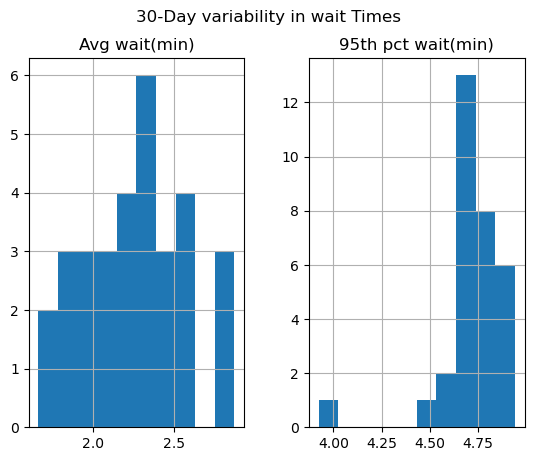

In [ ]:
days=31
daily=[]
for _ in range(days):
  w,_=simulate_with_abandon(opt[0])
  daily.append((w.mean()*60,np.percentile(w*60,95)))
df=pd.DataFrame(daily,columns=['Avg wait(min)','95th pct wait(min)'])
print(df)
df.hist(bins=10)
plt.suptitle('30-Day variability in wait Times')
plt.show()

In [ ]:
df.describe()

,Avg wait(min),95th pct wait(min)
count,31.000000,31.000000
mean,2.265743,4.719478
std,0.310073,0.176131
min,1.660560,3.924112
25%,2.047189,4.686362
50%,2.268363,4.730032
75%,2.475858,4.820337
max,2.873523,4.940171


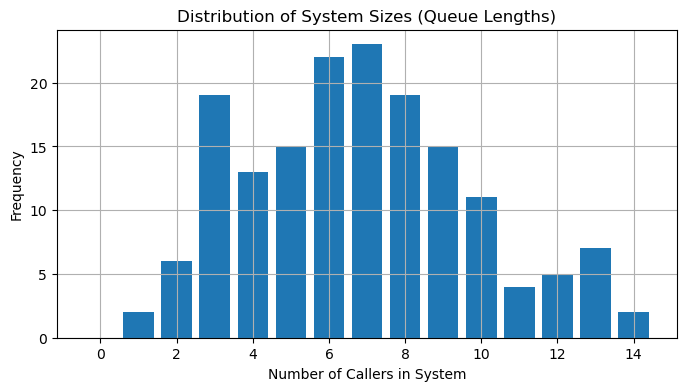

In [ ]:
# Plot the distribution of system sizes (queue lengths)
plt.figure(figsize=(8, 4))
plt.hist(system_sizes, bins=range(int(system_sizes.max()) + 2), align='left', rwidth=0.8)
plt.title("Distribution of System Sizes (Queue Lengths)")
plt.xlabel("Number of Callers in System")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## 5 Conclusion

We ran a call center simulation to find out how many agents we need to handle customer calls efficiently during an 8-hour workday. Here's what we found:

### Key Findings:
1. **Optimal Number of Agents**: 5 agents is the best choice because:
   - Most customers wait less than 5 minutes
   - Only about 5% of customers abandon their calls
   - It's the most cost-effective option when considering both staff costs ($20/hour) and customer wait costs ($0.50/minute)

2. **Call Patterns**:
   - Busiest times: Afternoon (40 calls/hour)
   - Moderate times: Morning (30 calls/hour)
   - Quieter times: Midday (20 calls/hour)

3. **Performance Metrics**:
   - Average wait time stays under 3 minutes
   - System can handle brief periods when one agent is on break
   - Queue length rarely exceeds 10 customers

### Recommendations:
1. **Staffing**: Keep 5 agents on duty for the full 8-hour shift
2. **Break Management**: Schedule breaks during quieter midday hours
3. **Monitoring**: Keep track of wait times and abandonment rates daily to maintain service quality

This setup provides a good balance between customer service quality and operational costs, making it the most practical choice for the call center.